In [1]:
from glob import glob
import numpy as np
import os.path as op

In [2]:
in_dir = '/home/data/nbc/external-datasets/ds001491/derivatives/afni-step1/'
subs = sorted(glob(op.join(in_dir, 'sub-*')))

for sub in subs:
    print(op.basename(sub))
    md_file = sorted(glob(op.join(sub, 'func/*_md_delt.1D')))[0]
    data = np.loadtxt(md_file)
    max_ = np.max(data)
    print('\t{0}'.format(max_))
    idx = np.where(data == max_)
    print('\t{0}'.format(idx[0][0]))

sub-01
	1.126
	486
sub-03
	0.869
	240
sub-04
	2.168
	156
sub-05
	0.595
	1
sub-06
	1.89
	152
sub-07
	3.494
	152
sub-08
	16.132
	395
sub-09
	1.933
	50
sub-10
	1.178
	15
sub-11
	7.929
	432
sub-12
	2.844
	8
sub-13
	3.071
	372
sub-14
	0.656
	1


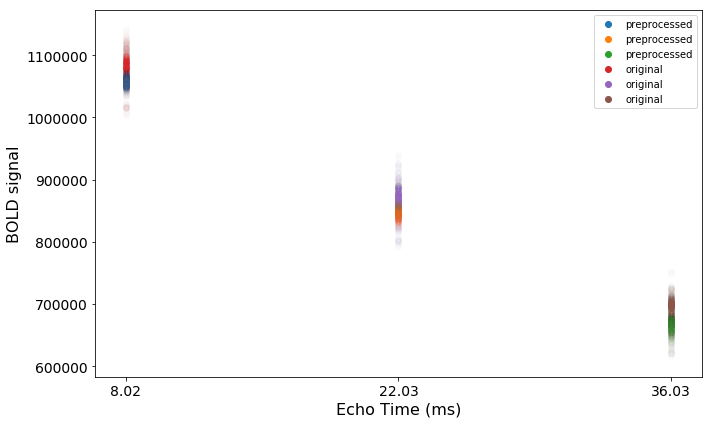

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nib

fig, ax = plt.subplots(figsize=(10, 6))

echo_times = np.array([8.02, 22.03, 36.03])
n_echoes = len(echo_times)
#echo_times = [-1 * e for e in echo_times]

files = ['sub-12_task-images_echo-1_desc-realign_bold.nii.gz',
         'sub-12_task-images_echo-2_desc-realign_bold.nii.gz',
         'sub-12_task-images_echo-3_desc-realign_bold.nii.gz']
files = [op.join('/home/data/nbc/external-datasets/ds001491/derivatives/afni-step1/sub-12/func', f) for f in files]

imgs = [nib.load(f) for f in files]
data = [img.get_data() for img in imgs]
ts = [d[31, 54, 18, :] for d in data]
n_trs = data[0].shape[-1]
#ts = [np.log(t) for t in ts]

for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.01, label='preprocessed')

files = ['sub-12_task-images_echo-1_bold.nii.gz',
         'sub-12_task-images_echo-2_bold.nii.gz',
         'sub-12_task-images_echo-3_bold.nii.gz']
files = [op.join('/home/data/nbc/external-datasets/ds001491/sub-12/func', f) for f in files]

imgs = [nib.load(f) for f in files]
data = [img.get_data() for img in imgs]
ts = [d[31, 54, 18, :] for d in data]
#ts = [np.log(t) for t in ts]

for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.01, label='original')

leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1.)

ax.set_ylabel('BOLD signal', fontsize=16)
ax.set_xlabel('Echo Time (ms)', fontsize=16)
ax.set_xticks(echo_times)
ax.tick_params(axis='both', which='major', labelsize=14)

#ax.set_ylim(5000, 40000)
fig.tight_layout()
fig.show()

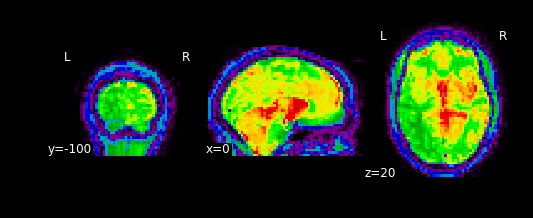

In [57]:
from nilearn import plotting

temp_data = imgs[0].get_data()[..., 0]
#temp_data = np.zeros(temp_data.shape)
temp_data[31, 54, 18] = 100000

temp_img = nib.Nifti1Image(temp_data, imgs[0].affine)
plotting.plot_epi(temp_img, cut_coords=[0, -100, 20], draw_cross=False)

In [68]:
# Prepare data for model
ts_1d = np.hstack(ts) # data raveled out (T * E)
log_data = np.log(np.abs(ts_1d) + 1)
# log_data = np.log(ts_1d)  # in a perfect world...
x = np.column_stack([np.ones(n_echoes), -1 * echo_times])
X = np.repeat(x, n_trs, axis=0)  # T * E

# Model fit
betas = np.linalg.lstsq(X, log_data, rcond=None)[0]
s0 = np.exp(betas[0])
r2s = betas[1]
t2s = 1. / r2s

In [73]:
from nilearn import masking
mask = masking.compute_epi_mask(imgs[0])
mask.to_filename('/home/data/nbc/external-datasets/ds001491/derivatives/epi_mask.nii')